# WIP

# Customer Segmentation
K-Means Clustering
---

Through customer segmentation (for example RFM score), we hope to better identify how different subsections of our customer base is purchasing. 

Doing this allows us to serve our customers better by hopefully providing insight into the products that they want; we can also inform them of promotions and products which they might be interested in, which will hopefully be more profitable for us -- a win/win. 

We can perform this segmentation in multiple ways (for example the component columns of RFM score), and provide different insights -- with multiple segmentations, we can compare within groups based on other factors.

2. By using the demographic information from hh_demographic, can we train a model to 'predict' the demographic information for the rest of our households? #xgboost

In [1]:
#### K-MEANS NOTES
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(16,6) 
plt.style.use('seaborn')

import my_funcs

In [2]:
merged = my_funcs.load_merged()

In [3]:
hh_agg = my_funcs.load_hh_agg(merged)

In [4]:
demo = my_funcs.load_demo()

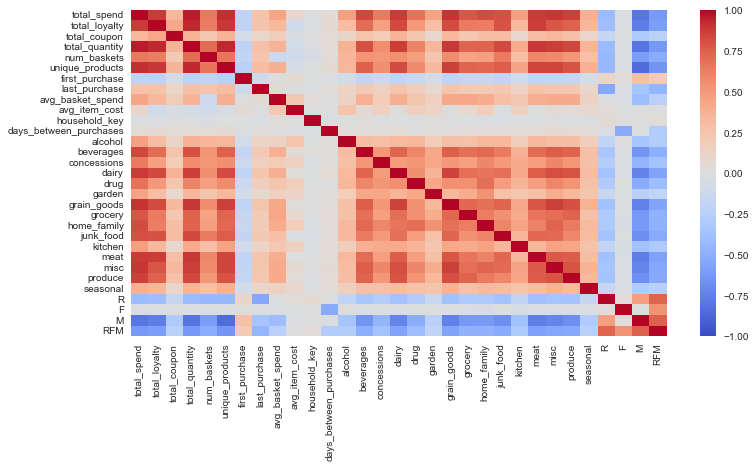

In [6]:
# inverting these columns for correlation visualization?
hh_agg['total_loyalty'] = hh_agg['total_loyalty'] * -1
hh_agg['total_coupon'] = hh_agg['total_coupon'] * -1

plt.figure(figsize=(12,6))
sns.heatmap(hh_agg.corr(), vmin=-1, vmax=1, cmap='coolwarm')

# inverting these columns
hh_agg['total_loyalty'] = hh_agg['total_loyalty'] * -1
hh_agg['total_coupon'] = hh_agg['total_coupon'] * -1

In [5]:
np.corrcoef(hh_agg['total_spend'], hh_agg['total_loyalty'])
# I wanted this correlation to appear as a positive one in the heatmap.

array([[ 1.        , -0.87602467],
       [-0.87602467,  1.        ]])

The total_spend category and the total_loyalty category are highly negatively correlated -- indicating that customers with the highest loyalty discounts are also the ones with the highest spend values in our dataset.

---

# Unsupervised learning; K-Means Clustering

K-Means clustering involves calculating the euclidean distance in a (multi-dimensional) feature space. It's a computationally intensive process where:
    - centroids are placed randomly in the (X-dimensional, ie 3-D) space.
    - the centroids try to move towards places of higher 'inertia', where they are in the middle of more data points

The parameters for the sklearn KMeans class are listed below:

    'n_clusters': 8,
    'init': 'k-means++',
    'max_iter': 300,
    'tol': 0.0001,
    'precompute_distances': 'deprecated',
    'n_init': 10,
    'verbose': 0,
    'random_state': None,
    'copy_x': True,
    'n_jobs': 'deprecated',
    'algorithm': 'auto'}

notice the `n_clusters`, `n_init` and `max_iter` methods; 

`n_clusters` refers to the number of centroids (and therefore cluster labels) which will be produced.

from the docs...

`n_init` : int, default=10
    Number of time the k-means algorithm will be run with different
    centroid seeds. The final results will be the best output of
    n_init consecutive runs in terms of inertia.

`max_iter` : int, default=300
    Maximum number of iterations of the k-means algorithm for a
    single run.

# Questions Before Preprocessing

I know this is `unsupervised learning`, but we need to think about two things here:

    - what proximity between data-points in a multi-dimensional euclidean space really means
    - what columns of data we're feeding our model; don't we already have 'cluster' labels?
    
To this point, I think an appropriate course of action would be to run the algorithm on several subsets of information that we've accumulated and pipe-lined to this point. The first thing I'd be interested to know about would be the similarity between the products that customers are purchasing. 

 - the first labels could be based on our derived section labels; the total spend in each category.
 - a second thought is to take the normalized per-basket category spend; one column for each category.
 - a third option would be to take some sort of timeseries or quarterly spend, using total or per-basket.
 

In [6]:
hh_agg.columns

Index(['household_key', 'total_spend', 'total_loyalty', 'total_coupon',
       'total_quantity', 'num_baskets', 'unique_products', 'first_purchase',
       'last_purchase', 'avg_basket_spend', 'avg_item_cost', 'alcohol',
       'beverages', 'concessions', 'dairy', 'drug', 'garden', 'grain_goods',
       'grocery', 'home_family', 'junk_food', 'kitchen', 'meat', 'misc',
       'produce', 'seasonal', 'days_between_purchases', 'R', 'F', 'M', 'RFM'],
      dtype='object')

## Creating subsections of hh_agg

In [7]:
hh_summary = hh_agg[['household_key', 'total_spend', 'total_loyalty', 'total_coupon',
       'total_quantity', 'num_baskets', 'unique_products', 'first_purchase',
       'last_purchase', 'avg_basket_spend', 'avg_item_cost','days_between_purchases']].copy()

In [8]:
hh_summary.set_index('household_key', inplace=True)

In [9]:
hh_products = hh_agg[['household_key', 'alcohol',
       'beverages', 'concessions', 'dairy', 'drug', 'garden', 'grain_goods',
       'grocery', 'home_family', 'junk_food', 'kitchen', 'meat', 'misc',
       'produce', 'seasonal']].copy()

In [10]:
hh_products.set_index('household_key', inplace=True)

In [11]:
# sns.heatmap(hh_products)
# this gives me an idea for timeseries analysis...

### Scaling the data

Scaling our data appropriately does a lot to improve the results and performance of this model. By normalizing our numeric columns between either -1 and 1; or 0 and 1; we give our model a better chance to interpret meaningful variance by eliminating the impact of 'scale' between columns with different units of measure.

## Scaling `hh_products`

In [12]:
prod_ss = StandardScaler().fit_transform(hh_products) 

The fit_transform method of the StandardScaler object returns a **2-D numpy array**. Since we didn't alter hh_products in place (beyond the index), we can simply call its index and columns to recreate a DataFrame;

In [13]:
# pd.DataFrame(prod_ss, index=hh_products.index, columns=hh_products.columns)

### Optimizing Centroids

I love this job. Where else do you get to say stuff like that?

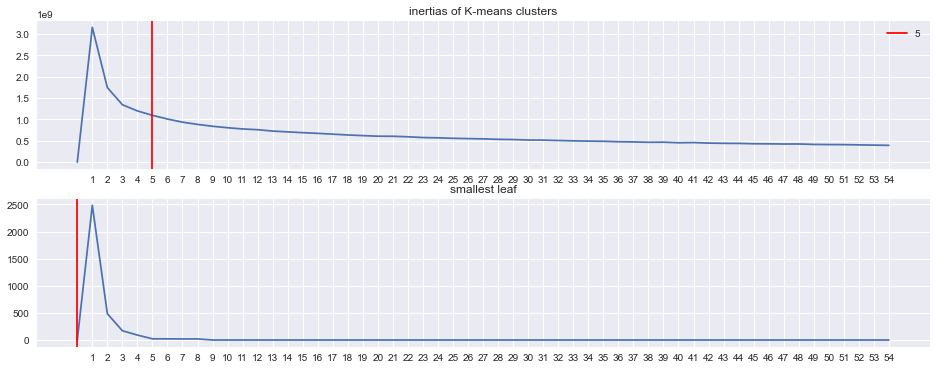

In [14]:
### Iterating to find optimal KMeans value
def plot_k_means_test(df, n_clusters=range(1,55)):
    inertias = []
    smallest = []
    for i in n_clusters:
        # instantiate

        KMM = KMeans(n_clusters=i)

        # fit
        KMM.fit(df)

        # evaluate
        inertias.append(KMM.inertia_)

        # note the smallest 'leaf'
        smallest.append(pd.Series(KMM.labels_).value_counts().min())
        
    inertias.insert(0,0)
    smallest.insert(0,0)

    # interpreting inertia and smallest_leaf_size for Kmeans Model
    plt.subplots(1,2, figsize=(16,6))

    plt.subplot(2,1,1)
    plt.title('inertias of K-means clusters')
    plt.plot(inertias)

    plt.xticks(n_clusters)
    plt.axvline(5, c='r', label='5')
    plt.legend()

    plt.subplot(2,1,2)
    plt.title('smallest leaf')
    plt.plot(smallest)
    plt.axvline(smallest[0], c='r')

    plt.xticks(n_clusters)
    plt.show();
plot_k_means_test(hh_products)

Hard to tell on the inertia plot, but the smallest leaf graph tells us what we want to know. When we have a cluster with 0 members, we know we've gone too far. 

5 labels would give us symmetry with our RFM scores; as well as the range for 'number of household members' in the demographic data. 

Call the function again on the other subset --

## Scaling and Plotting `hh_summary`

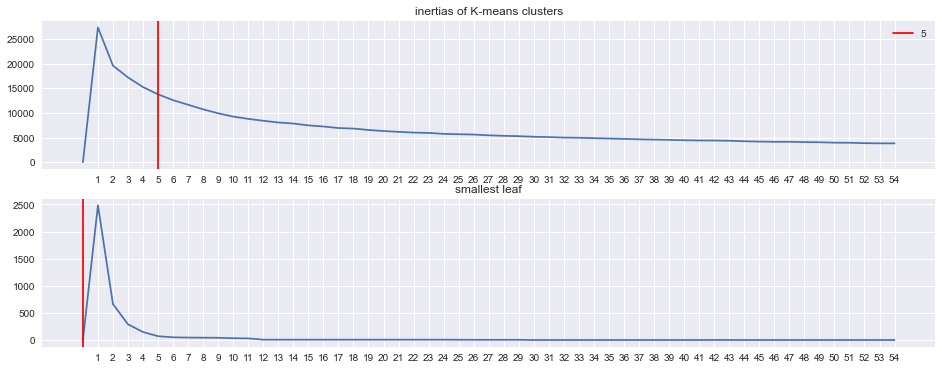

In [15]:
summary_ss = StandardScaler().fit_transform(hh_summary)
plot_k_means_test(summary_ss)

# Running final model and comparing with RFM score;

In [17]:

mymodel = KMeans(n_clusters=5, n_init=25, max_iter=500)

end_ss = mymodel.fit(hh_agg)
results = end_ss.labels_

In [19]:
len(results)

2485

In [20]:
hh_agg['KM5_Labels'] = results

In [ ]:
import seaborn as sns

In [32]:
import warnings
warnings.filterwarnings('ignore')

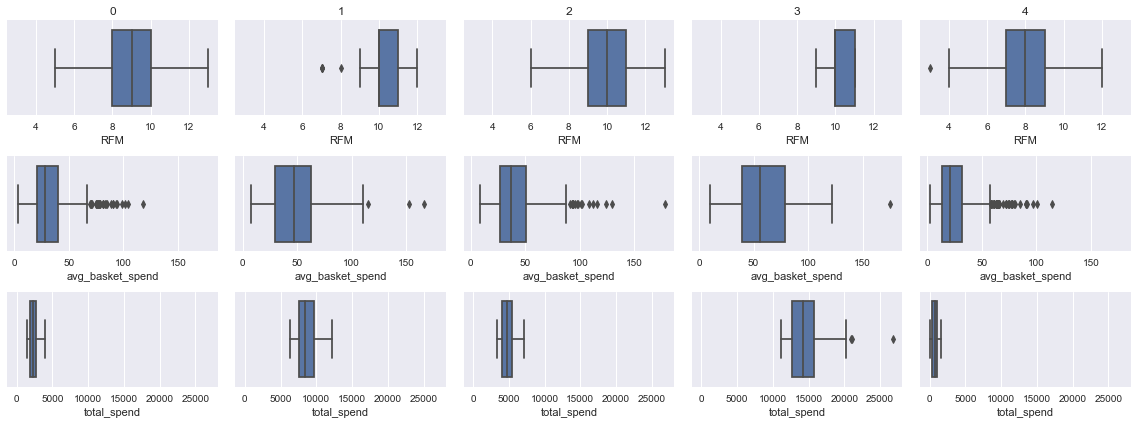

In [47]:
plt.subplots(3,5, figsize=(16,6), sharex='row')
for idx, label in enumerate(range(5)):
    df = hh_agg[hh_agg['KM5_Labels']==label]
    plt.subplot(3,5,idx+1)
    plt.title(f'{label}')
    sns.boxplot(df['RFM'])
    
    if idx+6>10:
        plt.title(f'avg. basket spend')
    plt.subplot(3, 5, idx+6)
    sns.boxplot(df['avg_basket_spend'])
    if idx+11>15:
        plt.title('total spend')
    plt.subplot(3, 5, idx+11)
    sns.boxplot(df['total_spend'])

plt.tight_layout()
plt.show()

We can see that the cluster labels seem to have distinct `total_spend` distributions. KM5_Labels 1 and 2 appear to be the most similar across these three categories, although groups 4 and 0 are also very similar.

In [48]:
hh_agg['KM5_Labels'].value_counts()

4    1049
0     754
2     470
1     170
3      42
Name: KM5_Labels, dtype: int64

Let's look at the difference between group 0 and group 4

In [57]:
hh_agg_4 = hh_agg[hh_agg['KM5_Labels'] == 4]
hh_agg_0 = hh_agg[hh_agg['KM5_Labels'] == 0]

pd.DataFrame([hh_agg_0.mean(), hh_agg_4.mean()])

,household_key,total_spend,total_loyalty,total_coupon,total_quantity,num_baskets,unique_products,first_purchase,last_purchase,avg_basket_spend,...,meat,misc,produce,seasonal,days_between_purchases,R,F,M,RFM,KM5_Labels
0,1226.692308,2384.373647,-457.423568,-2.215252,1120.440318,94.935013,518.561008,115.567639,694.307692,32.03105,...,516.935239,150.424111,248.253979,9.092361,8.987679,3.083554,2.594164,3.413793,9.091512,0.0
1,1240.341277,722.460877,-141.743746,-0.414824,335.593899,36.481411,190.251668,141.195424,664.986654,24.73870,...,148.867445,46.673365,76.538961,2.146635,31.201706,2.231649,4.174452,1.578646,7.984747,4.0


We can see that the groups diverge along `total_spend` mean, as well as `num_baskets`, `unique_products`, `meat`, `misc`, `produce` spending; as well as the `F` and `M` RFM columns.

And for labels 2 and 3:

In [59]:
hh_agg_3 = hh_agg[hh_agg['KM5_Labels'] == 3]
hh_agg_2 = hh_agg[hh_agg['KM5_Labels'] == 2]

pd.DataFrame([hh_agg_3.mean(), hh_agg_2.mean()])

,household_key,total_spend,total_loyalty,total_coupon,total_quantity,num_baskets,unique_products,first_purchase,last_purchase,avg_basket_spend,...,meat,misc,produce,seasonal,days_between_purchases,R,F,M,RFM,KM5_Labels
0,1472.880952,14792.421429,-2331.429524,-11.229524,6117.976190,321.095238,1857.714286,105.547619,706.357143,61.67698,...,2703.876429,901.722619,1690.163095,59.068095,2.997619,4.261905,1.119048,5.000000,10.380952,3.0
1,1255.455319,4824.735638,-900.716660,-5.790511,2208.651064,149.746809,875.708511,109.034043,700.840426,41.14691,...,1022.248638,297.419809,516.048106,13.499553,5.775489,3.480851,1.802128,4.606383,9.889362,2.0


These groups are again distinguishable along the `total_spend` mean, among other spending categories. It might be worth considering whether 'average section sales per basket' might be a better column. We note that KM5 Label 3 has a mean `M` score of 5 -- a perfect score -- with an `RFM` above 10. The KM5 Label 2 group has an `RFM` score approaching 10 -- still very good. 

Finally we should look at KM5_Label == 1

In [65]:
pd.DataFrame(hh_agg[hh_agg['KM5_Labels']==1].mean()).T

,household_key,total_spend,total_loyalty,total_coupon,total_quantity,num_baskets,unique_products,first_purchase,last_purchase,avg_basket_spend,...,meat,misc,produce,seasonal,days_between_purchases,R,F,M,RFM,KM5_Labels
0,1337.023529,8709.088824,-1477.384706,-11.216118,3728.435294,235.694118,1325.435294,106.747059,703.952941,50.324861,...,1694.091059,566.172765,915.005882,36.583706,4.020588,3.852941,1.317647,5.0,10.170588,1.0


Very low `F` score; but again we have a `M` mean of 5 -- among 170 households! This is suspicious. 

One thing that stands out to me about these 5 groups is the variance along the `days_between_purchases` mean value for each group; they have values close to: [3, 4, 5.75, 9, 31] across the various labels (these are not in order). To me this indicates that the model is recognizing the inherent value of a frequent purchaser -- it drives up the total spending differences!


In [1]:
# from itertools import cycle

# # setup plot details
# colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

<AxesSubplot:ylabel='Frequency'>

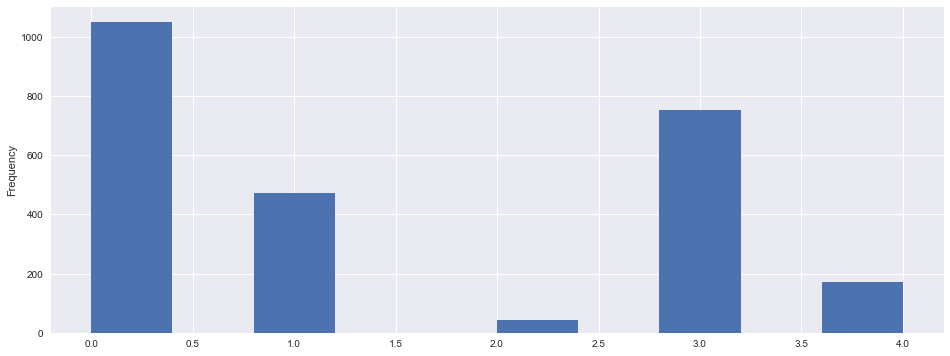

In [100]:
hh_agg.sort_values('KM5_Labels', ascending=False)['KM5_Labels'].plot(figsize=(16,6), kind='barh')

In [115]:
newresults = dict()
for col in ['R', 'F', 'M', 'RFM']:
    newresults[col] = dict()
    for label in hh_agg[col].unique():
        data = hh_agg[hh_agg[col]==label]
        newresults[col][label] = int(data[col].value_counts())
        

In [132]:
for col in newresults:
    print(newresults[col].items())

dict_items([(4, 638), (1, 501), (3, 518), (2, 537), (5, 291)])
dict_items([(3, 499), (4, 495), (1, 497), (2, 497), (5, 497)])
dict_items([(4, 497), (3, 497), (2, 497), (5, 497), (1, 497)])
dict_items([(11, 341), (8, 435), (7, 440), (9, 515), (10, 554), (6, 119), (12, 54), (5, 17), (13, 8), (3, 1), (4, 1)])


# TODO:
- which categories my best customers purchase in -- how sales are being affected over time or by campaigns

- Compare demographic_hh categories by sales
- Generate labels based on cleaned transactions data
    - sum of sales by section, divided by total spend? number of transactions?
- Compare RFM score with Cluster Labels



#### CHECKING CORRELATION BETWEEN SECTION SALES OVER TIME ####
- PACF?
- PCT CHANGE?
- REMOVE TREND/SEASONALITY THEN COMPARE PCT.CHANGE?

In [ ]:
# import seaborn as sns

# mycontainer = dict()
# for dept in merged['Section Label'].unique():
#     mycontainer[dept] = merged[merged['Section Label']==dept].groupby('WEEK_NO')['SALES_VALUE'].sum()

# a = pd.DataFrame(mycontainer)
# a.pct_change().drop(1)

# mask = np.triu(a.pct_change().drop(1).corr())
# sns.heatmap(a.pct_change().drop(1).corr(), mask=mask, annot=True, vmin=-1, vmax=1, cmap='coolwarm')